
### Recognising Traffic Signs Using Deep Learning
#### Bashini Mahaarachchi

#### Importing necessary libraries and modules

In [1]:
# Importig libraries and modules

import h5py
from utils import*
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import cv2
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Flatten, Conv2D, MaxPooling2D
from PIL import Image
from imgaug import augmenters as iaa
import os
import time
import warnings
warnings.simplefilter("ignore")

Using TensorFlow backend.


#### Importing data and splitiing the training test and validation sets

The dataset used for this project consists of 43 different traffic signs seen on German roads. The traffic sign images were cropped from actual road images and hence are under varying conditions of lighting.(Feference: http://benchmark.ini.rub.de/)


In [2]:
# Loading pickled data

datasets_path = "./Data3/" 

training_file = datasets_path + 'train.p'
validation_file= datasets_path + 'valid.p'
testing_file = datasets_path + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
image_shape = X_train.shape[1:]
n_classes = len(set(y_train))

In [3]:
# Printing the dimensions of the training and validation sets
print("Training set shape: ", X_train.shape)
print("Lables shape: ", y_train.shape)
print("Validation set shape: ", X_valid.shape)
print("Test set shape: ", X_test.shape)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Training set shape:  (34799, 32, 32, 3)
Lables shape:  (34799,)
Validation set shape:  (4410, 32, 32, 3)
Test set shape:  (12630, 32, 32, 3)
Image data shape = (32, 32, 3)
Number of classes = 43


##  Data Exploration ##

#### Grouping the images by class

My first step is to import the signnames.csv file which contains English description of the labels.

In [4]:
# Loading sign names file
sign_names = pd.read_csv("./Data3/Signnames.csv")
sign_names.set_index("ClassId")
sign_names.head(n=3)

ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)

#### Functions to group the images by the class label

In [5]:
def group_img_id_to_lbl(y_train,sign_names):    
    arr_map = []
    for i in range(0, y_train.shape[0]):
        for j in range(0, 43):
            label_id = y_train[i,j]
            if label_id == 1.0:
                x =j
                label_name = sign_names[sign_names["ClassId"] == j]["SignName"][j]
                arr_map.append({"img_id": i, "label_id": j, "label_name": label_name})

    return pd.DataFrame(arr_map)

In [6]:
def group_img_id_to_lbl_2(lbs_ids, lbs_names):    
    
    #Function to group images by label 
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})

    return pd.DataFrame(arr_map)

In [7]:
def group_img_id_to_lb_count(img_id_to_lb):
    
    #Returning a pivot table table indexed by label id and label name.
   
    return pd.pivot_table(img_id_to_lb, index=["label_id", "label_name"], values=["img_id"], aggfunc='count')

In [8]:
X_train_id_to_label = group_img_id_to_lbl_2(y_train, sign_names)
X_train_id_to_label.head(n=3)

img_id  label_id         label_name
0       0        41  End of no passing
1       1        41  End of no passing
2       2        41  End of no passing

In [9]:
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
Hist1 = X_train_id_to_label.groupby(["label_id", "label_name"]).size().reset_index(name="Count")

### Basic Descriptive analysis ###

I am going to see the distribution on the training data.

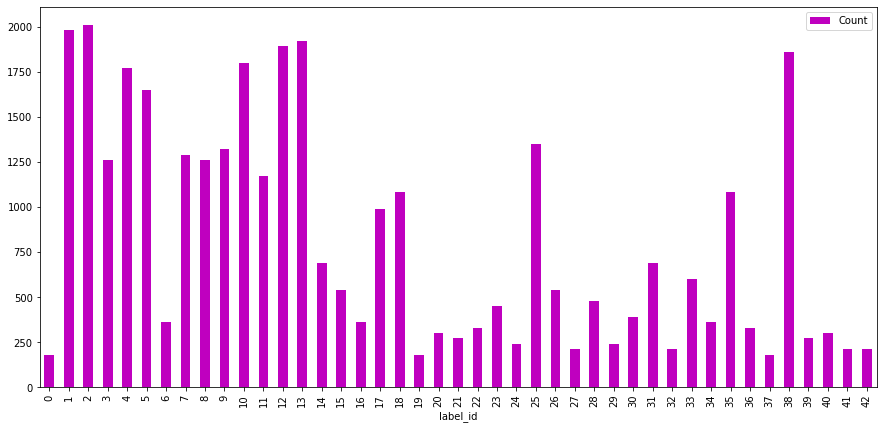

In [10]:
Hist1.plot("label_id","Count", kind='bar', figsize=(15, 7), color = "m")

It can be seen that there exists the class bias issue as certain classes are under represented. I will later try to run the model with a more balanced training data.

### Training Set Image Visualization ###

First I am going to randomly plot 40 images of the training set.

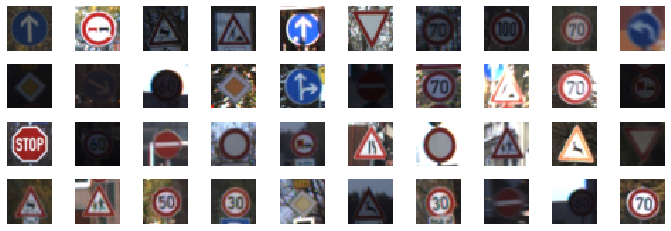

In [11]:
%matplotlib inline
fig, axs = plt.subplots(4,10, figsize=(12, 4))
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)  

Now I am going to plot few images of the training set with the same class label.

In [21]:
def show_image_list(img_list, img_labels, title, cols=3, fig_size=(10, 10), show_ticks=True):
 
    #img_count = 10
    img_count = len(img_list)
    rows = img_count // cols
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, img_count):
        img_name = img_labels[i]     
        img = img_list[i]
        if len(img.shape) < 3 or img.shape[-1] < 3:
            cmap = "gray"
            img = np.reshape(img, (img.shape[0], img.shape[1]))

        if not show_ticks:            
            axes[i].axis("off")
        axes[i].imshow(img, cmap=cmap)

    fig.suptitle(title, fontsize=12, fontweight='bold', y = 0.62)
    fig.tight_layout()
    plt.show(block=False )

    return

In [22]:
def show_random_dataset_images(group_label, imgs, to_show=5):
    for (lid, lbl), group in group_label:
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=to_show, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_img = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        selected_labels = list(map(lambda label_id: label_id, selected_rows['label_id']))
        show_image_list(selected_img, selected_labels, "{0}: {1}".format(lid, lbl), cols=to_show, fig_size=(5, 5), show_ticks=False)

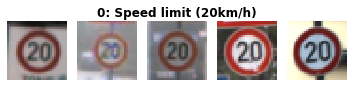

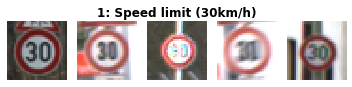

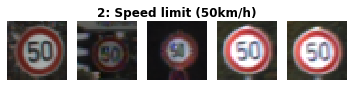

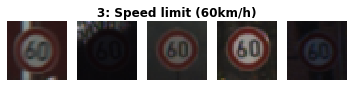

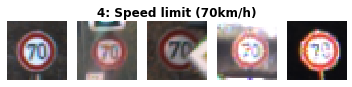

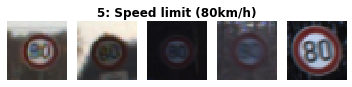

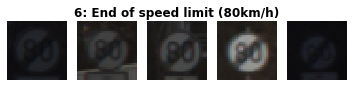

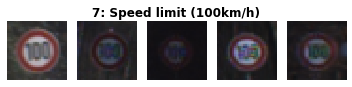

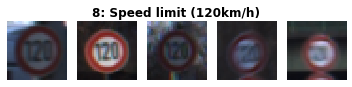

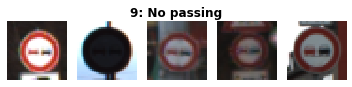

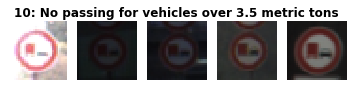

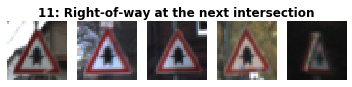

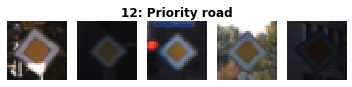

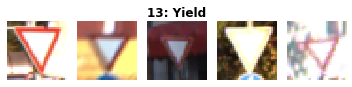

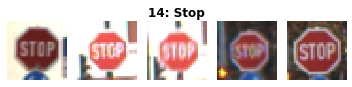

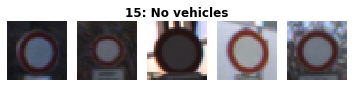

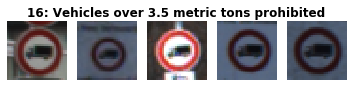

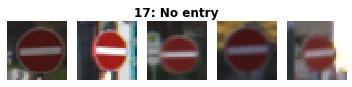

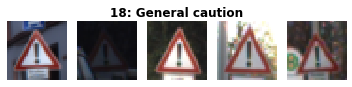

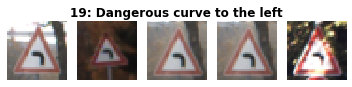

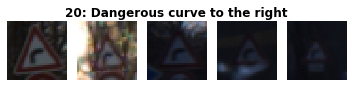

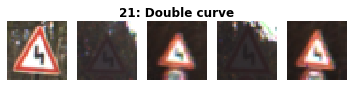

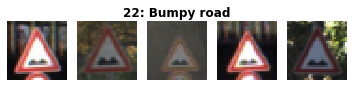

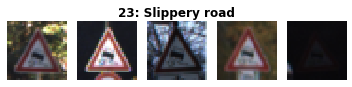

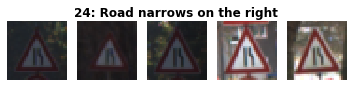

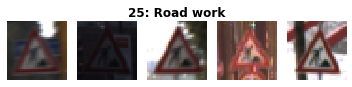

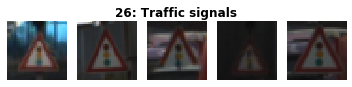

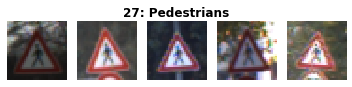

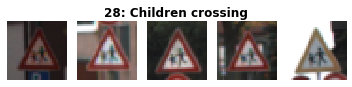

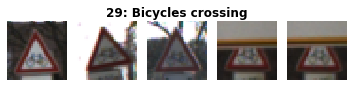

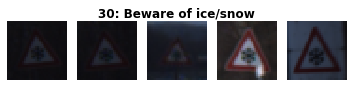

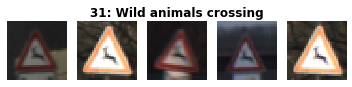

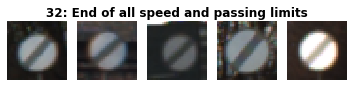

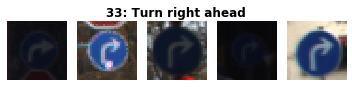

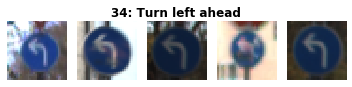

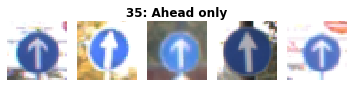

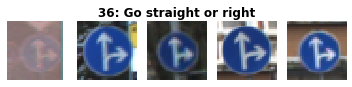

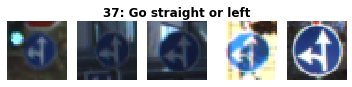

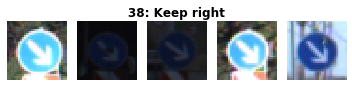

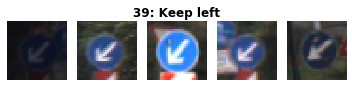

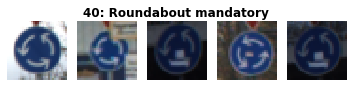

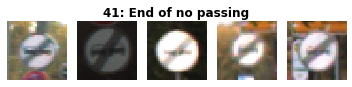

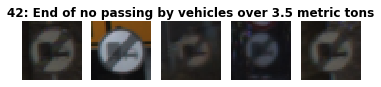

In [14]:
show_random_dataset_images(X_train_group_by_label, X_train)

Now I am going to visualize the validation data.

In [15]:
X_val_id_to_label = group_img_id_to_lbl_2(y_valid, sign_names)
X_val_id_to_label.head(n=3)

img_id  label_id         label_name
0       0        41  End of no passing
1       1        41  End of no passing
2       2        41  End of no passing

Now I am going to see the distribution on the validation data.

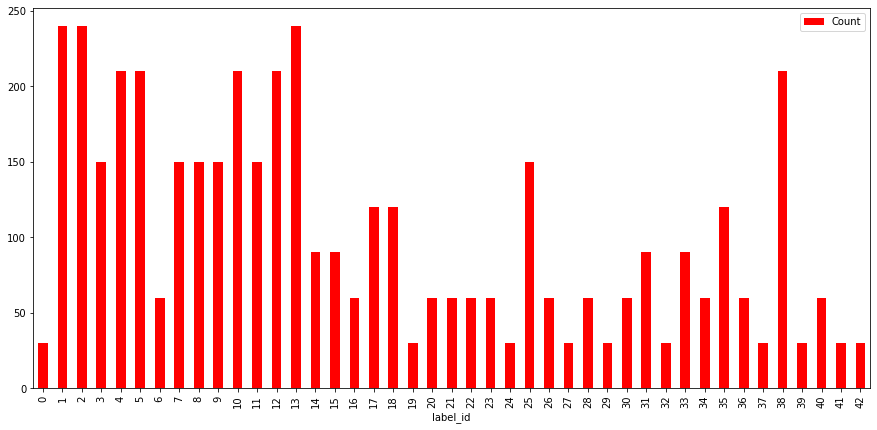

In [16]:
X_val_group_by_label = X_val_id_to_label.groupby(["label_id", "label_name"])
Hist2 = X_val_id_to_label.groupby(["label_id", "label_name"]).size().reset_index(name="Count")
Hist2.plot("label_id","Count", kind='bar', figsize=(15, 7), color = "r")

Now I am going to plot few images of the validation set with the same class label.

In [17]:
X_val_group_by_label = X_val_id_to_label.groupby(["label_id", "label_name"])

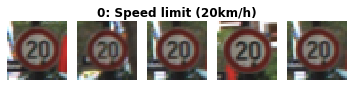

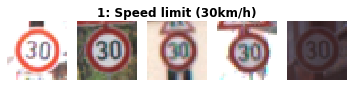

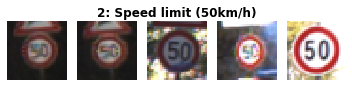

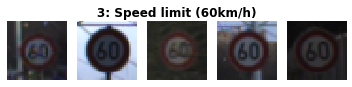

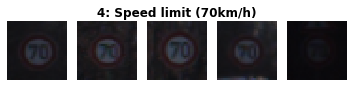

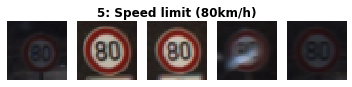

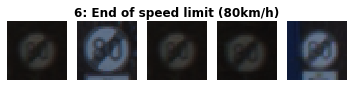

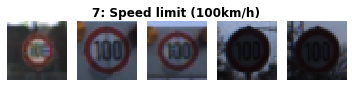

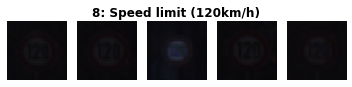

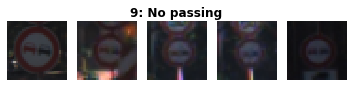

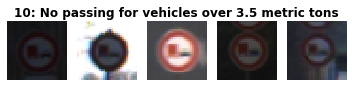

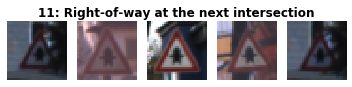

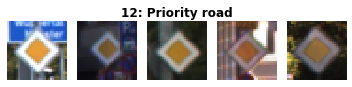

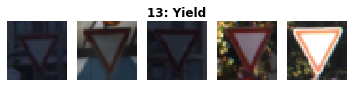

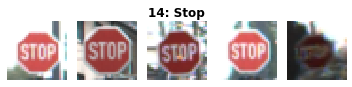

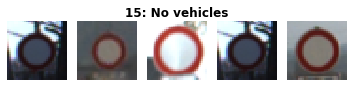

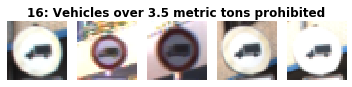

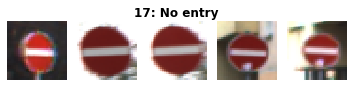

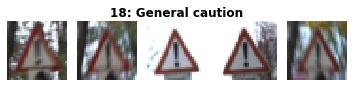

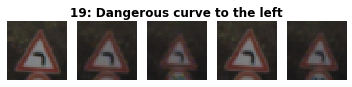

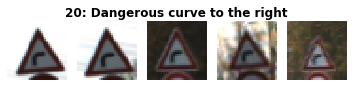

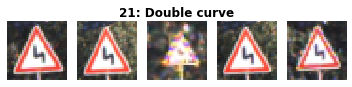

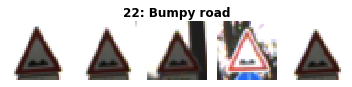

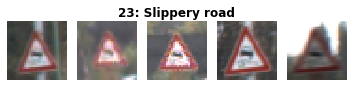

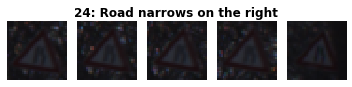

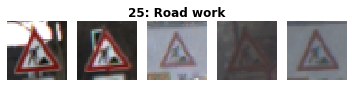

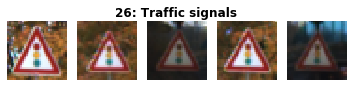

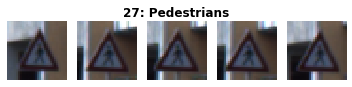

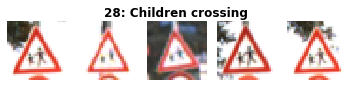

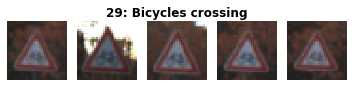

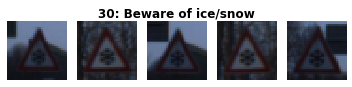

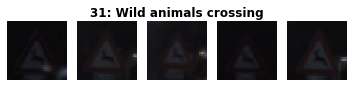

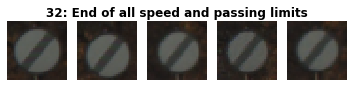

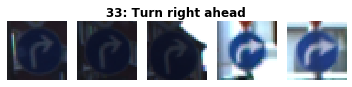

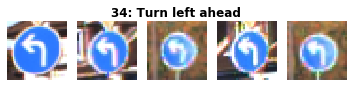

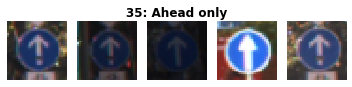

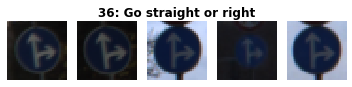

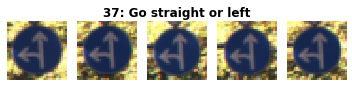

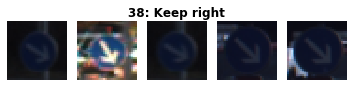

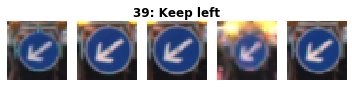

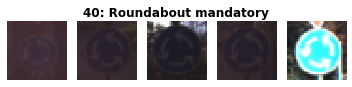

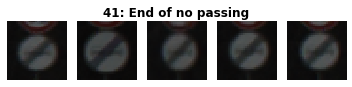

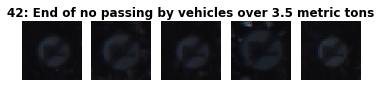

In [18]:
show_random_dataset_images(X_val_group_by_label, X_valid)

As same as in the training set validation set also has too much dark and too much bright images. and some of the images are disorted. I am going to try to find a solution to these issues in later steps.

### Generating a baseline model without preprocessing ###

To understand where the model stands without doing any preprocessing I am going to use a simple **“dense/fully connected”** neural network architecture for baseline scores and other testing.

In [19]:
def dense_nn(X_train, y_train, X_valid, y_val, X_test_baseline,y_test_baseline, shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape= shape))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    mod1 = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_valid, y_val))
    
    return model,mod1

Fitting the model for unprocessed data.

In [20]:
X_train_baseline = X_train.reshape(len(X_train), 32*32*3).astype('float32')
X_val_baseline = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
X_test_baseline = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train, n_classes)
y_val_baseline = keras.utils.to_categorical(y_valid, n_classes)
y_test_baseline = keras.utils.to_categorical(y_test, n_classes)

In [21]:
model_baseline,model_baseline_fit = dense_nn(X_train_baseline,y_train_baseline,X_val_baseline,y_val_baseline,X_test_baseline, y_test_baseline, shape = (32*32*3,))


Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 8s 236us/step - loss: 2.6777 - accuracy: 0.2868 - val_loss: 2.1848 - val_accuracy: 0.3746
Epoch 2/100
34799/34799 [==============================] - 5s 151us/step - loss: 1.3229 - accuracy: 0.5885 - val_loss: 1.3343 - val_accuracy: 0.6002
Epoch 3/100
34799/34799 [==============================] - 5s 132us/step - loss: 0.9093 - accuracy: 0.7197 - val_loss: 0.9312 - val_accuracy: 0.6975
Epoch 4/100
34799/34799 [==============================] - 5s 135us/step - loss: 0.7290 - accuracy: 0.7791 - val_loss: 0.7218 - val_accuracy: 0.7787
Epoch 5/100
34799/34799 [==============================] - 5s 153us/step - loss: 0.6127 - accuracy: 0.8150 - val_loss: 0.8482 - val_accuracy: 0.7694
Epoch 6/100
34799/34799 [==============================] - 5s 146us/step - loss: 0.5432 - accuracy: 0.8350 - val_loss: 0.8506 - val_accuracy: 0.7585
Epoch 7/100
34799/34799 [==============================]

Epoch 54/100
34799/34799 [==============================] - 6s 170us/step - loss: 0.1625 - accuracy: 0.9496 - val_loss: 0.4952 - val_accuracy: 0.8692
Epoch 55/100
34799/34799 [==============================] - 6s 165us/step - loss: 0.1558 - accuracy: 0.9523 - val_loss: 0.4672 - val_accuracy: 0.8939
Epoch 56/100
34799/34799 [==============================] - 5s 150us/step - loss: 0.1615 - accuracy: 0.9493 - val_loss: 0.4539 - val_accuracy: 0.8986
Epoch 57/100
34799/34799 [==============================] - 5s 141us/step - loss: 0.1508 - accuracy: 0.9529 - val_loss: 0.4419 - val_accuracy: 0.8950
Epoch 58/100
34799/34799 [==============================] - 5s 149us/step - loss: 0.1498 - accuracy: 0.9534 - val_loss: 0.4717 - val_accuracy: 0.8871
Epoch 59/100
34799/34799 [==============================] - 5s 140us/step - loss: 0.1503 - accuracy: 0.9533 - val_loss: 0.5067 - val_accuracy: 0.8780
Epoch 60/100
34799/34799 [==============================] - 7s 196us/step - loss: 0.1530 - accuracy:

Now I am going to plot the model results.

In [22]:
model_baseline.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
Pred = model_baseline.evaluate(X_test_baseline, y_test_baseline, verbose=0)
print("Dense fully connected network results on the test data - Baseline ")
print(" ")
print("%s- %.2f" % (model_baseline.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model_baseline.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - Baseline 
 
loss- 1.60
accuracy- 0.87


In [37]:
def plot_acc_loss(model):
    # summarize history for accuracy
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    accuracy_plot = plt.show()

    # summarize history for loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    loss_plot = plt.show()

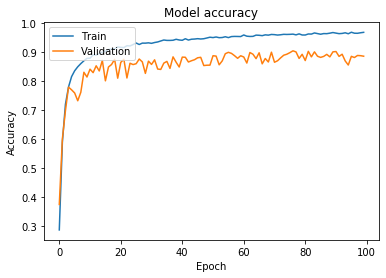

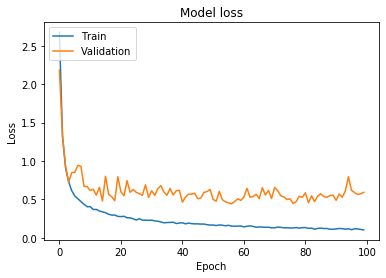

In [24]:
plot_acc_loss(model_baseline_fit)

The model is able to achieve an accuracy score of 87% without any preprocessing.

The Activation function used here is is “relu”. 

There are 4 hidden layers of 128 neurons with relu activation and after each hidden layer except the last one a dropout(50%) function is included.
The output layer has the softmax activation since this is a multi class classification and there are 43 classes.

### Data Preprocessing ###

Now I am ging to see if preprocessing the images would lead to a better accuracy score.

#### Normalisation ####

Fist I am going to normalise the data.

In [25]:
def normalise_images(imgs, dist):
    std = np.std(dist)
    mean = np.mean(dist)
    return (imgs - mean) / std

In [26]:
# Normalise training and validation sets
X_train_normalised = normalise_images(X_train, X_train)
X_val_normalised = normalise_images(X_valid, X_train) 
X_test_normalised = normalise_images(X_test, X_train) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


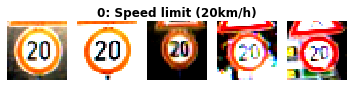

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


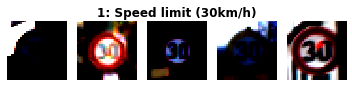

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


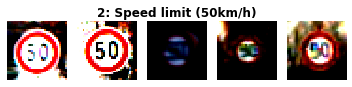

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


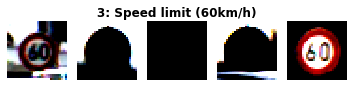

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


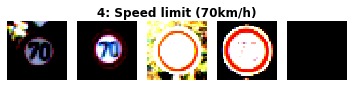

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


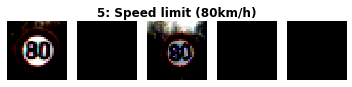

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


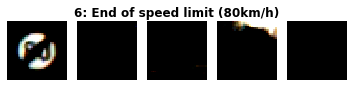

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


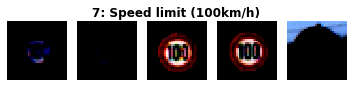

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


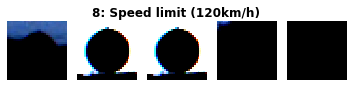

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


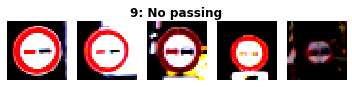

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


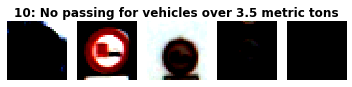

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


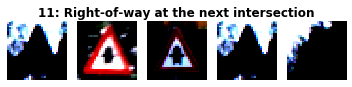

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


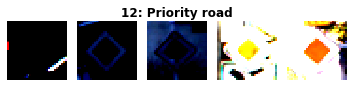

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


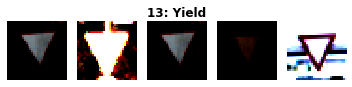

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


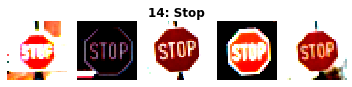

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


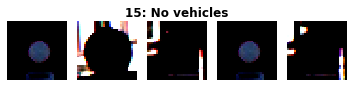

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


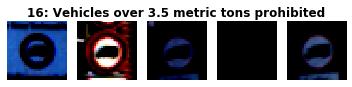

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


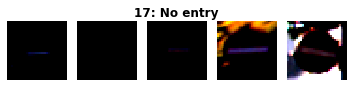

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


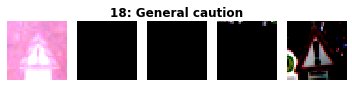

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


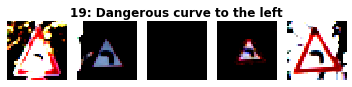

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


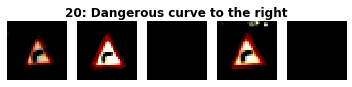

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


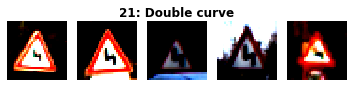

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


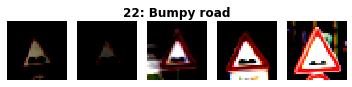

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


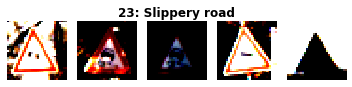

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


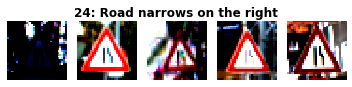

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


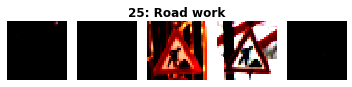

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


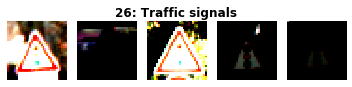

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


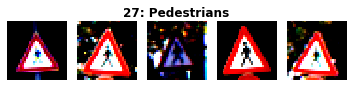

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


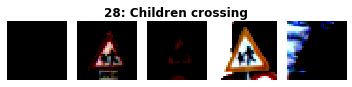

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


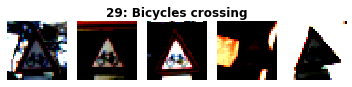

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


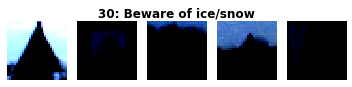

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


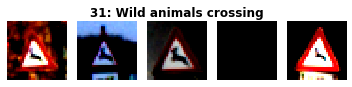

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


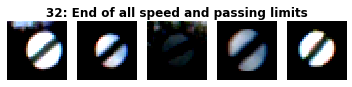

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


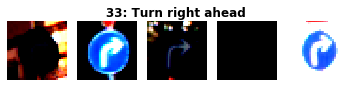

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


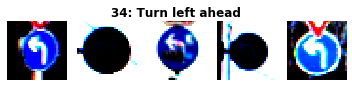

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


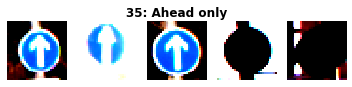

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


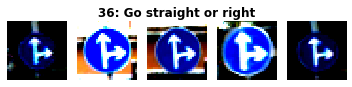

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


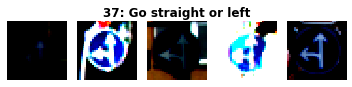

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


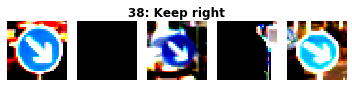

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


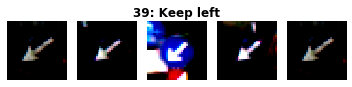

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


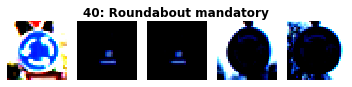

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


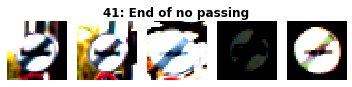

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


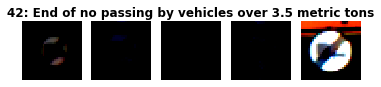

In [27]:
show_random_dataset_images(X_train_group_by_label, X_train_normalised)

It can be seen that normalizing has made images even darker. I will test on this data later.

#### Grayscaling ####

In [13]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

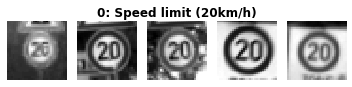

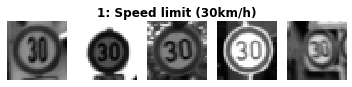

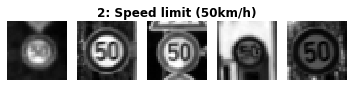

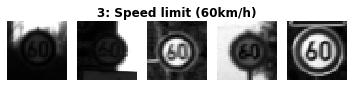

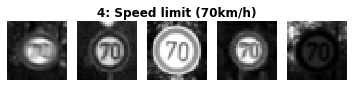

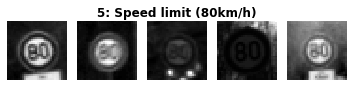

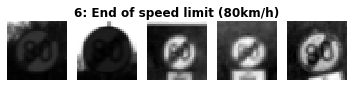

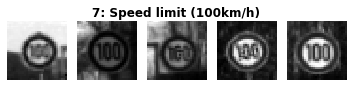

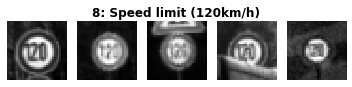

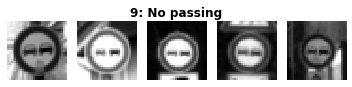

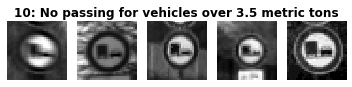

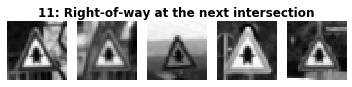

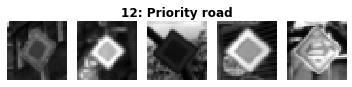

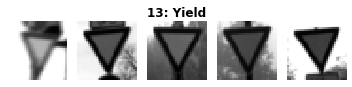

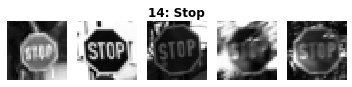

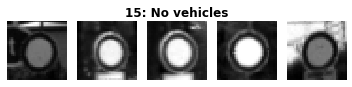

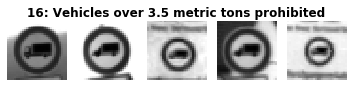

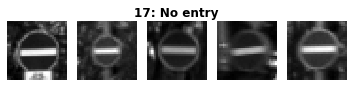

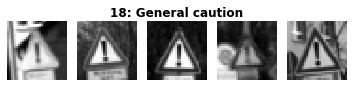

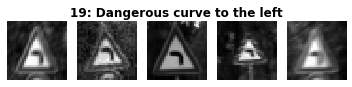

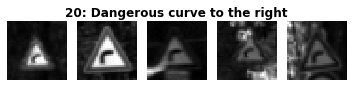

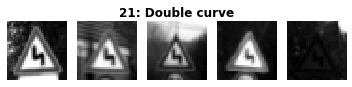

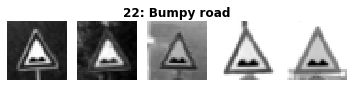

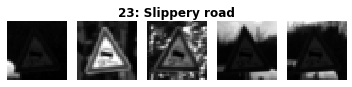

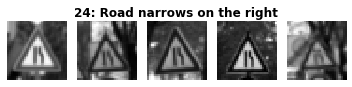

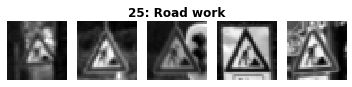

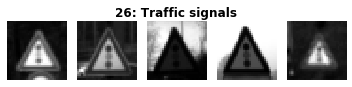

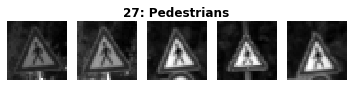

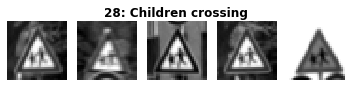

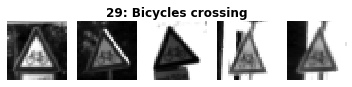

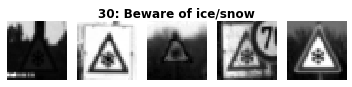

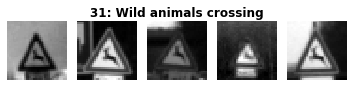

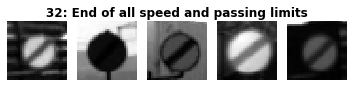

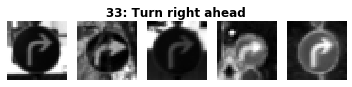

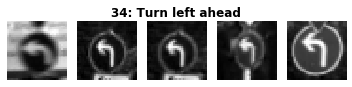

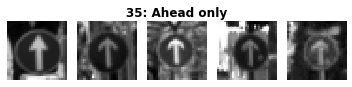

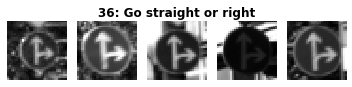

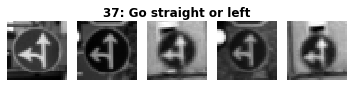

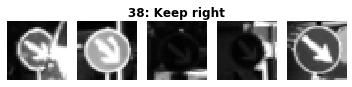

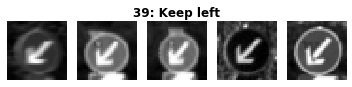

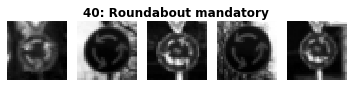

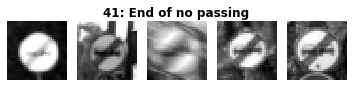

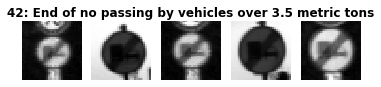

In [30]:
# Now I am going to convert the training validation and test sets to grayscale.
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train))) 
X_val_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_valid))) 
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test)))
show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

It can be seen that grayscaling improves the visibility of the images to some extent, but some of them still remain very dark.

### Tesing the feedforward network architecture with the processed data

First I am going to test the model with normalized data.

In [30]:
X_train_normalised_model = X_train_normalised.reshape(len(X_train_normalised), 32*32*3).astype('float32')
X_val_normalised_model = X_val_normalised.reshape(len(X_val_normalised), 32*32*3).astype('float32')
X_test_normalised_model = X_test_normalised.reshape(len(X_test_normalised), 32*32*3).astype('float32')
y_train_normalised_model = keras.utils.to_categorical(y_train, n_classes)
y_val_normalised_model = keras.utils.to_categorical(y_valid, n_classes)
y_test_normalised_model = keras.utils.to_categorical(y_test, n_classes)

In [31]:
normalised_model,normalised_model_fit = dense_nn(X_train_normalised_model,y_train_normalised_model,X_val_normalised_model,y_val_normalised_model,X_test_normalised_model,y_test_normalised_model, shape =(32*32*3,))

Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 9s 253us/step - loss: 2.7140 - accuracy: 0.2726 - val_loss: 1.8021 - val_accuracy: 0.4299
Epoch 2/100
34799/34799 [==============================] - 5s 154us/step - loss: 1.3922 - accuracy: 0.5694 - val_loss: 1.1536 - val_accuracy: 0.6200
Epoch 3/100
34799/34799 [==============================] - 5s 151us/step - loss: 0.9943 - accuracy: 0.6960 - val_loss: 1.1137 - val_accuracy: 0.6624
Epoch 4/100
34799/34799 [==============================] - 6s 160us/step - loss: 0.8002 - accuracy: 0.7555 - val_loss: 0.8253 - val_accuracy: 0.7526
Epoch 5/100
34799/34799 [==============================] - 6s 163us/step - loss: 0.6853 - accuracy: 0.7912 - val_loss: 0.7346 - val_accuracy: 0.7712
Epoch 6/100
34799/34799 [==============================] - 5s 155us/step - loss: 0.5838 - accuracy: 0.8239 - val_loss: 0.8510 - val_accuracy: 0.7374
Epoch 7/100
34799/34799 [==============================] 

In [32]:
normalised_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
Pred_normalised = normalised_model.evaluate(X_test_normalised_model, y_test_normalised_model, verbose=0)
print("Dense fully connected network results on the test data - Normalised ")
print(" ")
print("%s- %.2f" % (normalised_model.metrics_names[0], Pred_normalised[0]))
print("%s- %.2f" % (normalised_model.metrics_names[1], Pred_normalised[1]))

Dense fully connected network results on the test data - Normalised 
 
loss- 1.07
accuracy- 0.81


Plotting the model accuracy and loss.

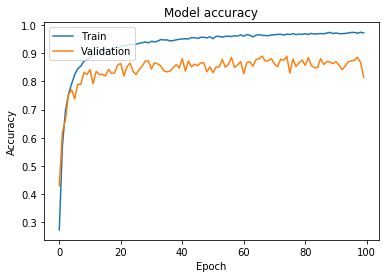

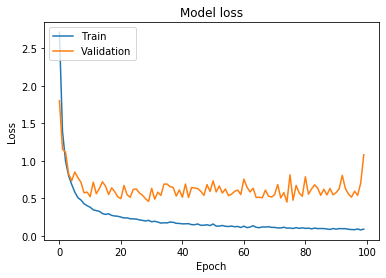

In [33]:
plot_acc_loss(normalised_model_fit)

Now I am going to test the model with the grayscaled data.

In [31]:
X_train_grayscale_model = X_train_grayscale.reshape(len(X_train_grayscale), 32*32*1).astype('float32')
X_val_grayscale_model = X_val_grayscale.reshape(len(X_val_grayscale), 32*32*1).astype('float32')
X_test_grayscale_model = X_test_grayscale.reshape(len(X_test_grayscale), 32*32*1).astype('float32')
y_train_grayscale_model = keras.utils.to_categorical(y_train, n_classes)
y_val_grayscale_model = keras.utils.to_categorical(y_valid, n_classes)
y_test_grayscale_model = keras.utils.to_categorical(y_test, n_classes)

In [35]:
grayscaled_model, grayscaled_model_fit = dense_nn(X_train_grayscale_model,y_train_grayscale_model,X_val_grayscale_model,y_val_grayscale_model,X_test_grayscale_model,y_test_grayscale_model,shape =(32*32*1,))

Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 7s 206us/step - loss: 2.8081 - accuracy: 0.2617 - val_loss: 1.9306 - val_accuracy: 0.3982
Epoch 2/100
34799/34799 [==============================] - 4s 111us/step - loss: 1.4454 - accuracy: 0.5677 - val_loss: 1.6796 - val_accuracy: 0.5045
Epoch 3/100
34799/34799 [==============================] - 4s 108us/step - loss: 1.0596 - accuracy: 0.6811 - val_loss: 0.9267 - val_accuracy: 0.7379
Epoch 4/100
34799/34799 [==============================] - 4s 117us/step - loss: 0.8696 - accuracy: 0.7375 - val_loss: 0.9247 - val_accuracy: 0.7390
Epoch 5/100
34799/34799 [==============================] - 4s 108us/step - loss: 0.7958 - accuracy: 0.7651 - val_loss: 0.7804 - val_accuracy: 0.7615
Epoch 6/100
34799/34799 [==============================] - 4s 110us/step - loss: 0.7146 - accuracy: 0.7874 - val_loss: 0.7315 - val_accuracy: 0.7807
Epoch 7/100
34799/34799 [==============================] 

Plotting the accuracy and loss of the grayscaled model.

In [36]:
grayscaled_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
Pred_grayscaled = grayscaled_model.evaluate(X_test_grayscale_model, y_test_grayscale_model, verbose=0)
print("Dense fully connected network results on the test data - Grayscaled ")
print(" ")
print("%s- %.2f" % (grayscaled_model.metrics_names[0], Pred_grayscaled[0]))
print("%s- %.2f" % (grayscaled_model.metrics_names[1], Pred_grayscaled[1]))

Dense fully connected network results on the test data - Grayscaled 
 
loss- 0.70
accuracy- 0.87


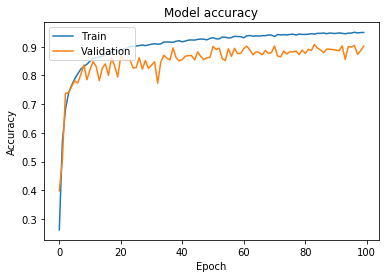

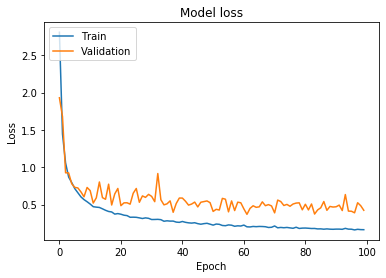

In [37]:
plot_acc_loss(grayscaled_model_fit)

### Data Augmantation

The class imbalance between the 43 classes could be observed in data.I also noticed that some images in the test set are distorted. I am therefore going to use data augmentation techniques as an attempt to:

 - Minimize imbalances across classes
 - Extend dataset and provide additional pictures in different lighting settings and orientations
 - Improve model's ability to become more generic
 - Improve test and validation accuracy, especially on distorted images

In the following function I am going to make 40% extra samples from the classes which has less than 250 observations in the training set. And for the remaining classes I am creating 10% more samples.The new images are created by adjusting the rotation, cropping the images by 4 pixels and the adjusting the distorted images though shear adjustments.

In [10]:
def augment_imgs(imgs, p):
    
    #Performing a set of augmentations with a probability p
    
    augs =  iaa.SomeOf((1, 2),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
              iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
          ])

    seq = iaa.Sequential([iaa.Sometimes(p, augs)])

    return seq.augment_images(imgs)

def augment_imgs_until_n(imgs, n, p):
    
    #Taking the augmented images with a probability p, until n augmentations have been created.
    
    i = 0
    aug_imgs = []
    while i < n:
        augs = augment_imgs(imgs, p)
        i += len(augs)
        aug_imgs = augs if len(aug_imgs) == 0 else np.concatenate((aug_imgs, augs))

    return aug_imgs[0 : n]

In [11]:
X_train_augs = X_train
y_train_augs = X_train_id_to_label.iloc[:,1].values


# This loop augments images per label group
for (lid, lbl), group in X_train_group_by_label:
    #print("[{0}] : {1}".format(lid, lbl))   
    group_count = group['img_id'].size
    idx = group['img_id'].values
    imgs = X_train[idx]
    
    # Taking a different population of the subset depending on how many images are already there 
    #and changing the number of augmentations depending on size of label/class group
    pt_spacing = 1.0
    p = 1.0
    
    #n = group_count * 0.1
    
    if group_count > 0 and group_count < 250:
        pt_spacing = 3.0
        n = group_count * 0.4
    elif group_count >= 250:
        n = group_count * 0.1
        pt_spacing = 20.0
    
    n = int(n)
    
    space_interval = int(group_count / pt_spacing)
    
    rand_idx = np.linspace(0, group_count, num=space_interval, endpoint=False, dtype='int')
    
    selected_rows = group.iloc[rand_idx]
    selected_img = np.array(list(map(lambda img_id: X_train[img_id], selected_rows['img_id'])))
    
    augs = augment_imgs_until_n(selected_img, n, p)
    X_train_augs = np.concatenate((X_train_augs, augs))
    y_train_augs = np.concatenate((y_train_augs, np.repeat(lid,n)))
    
print("New Augmented arrays shape: {0} and {1}".format(X_train_augs.shape, y_train_augs.shape))

New Augmented arrays shape: (38836, 32, 32, 3) and (38836,)


Now I am going to plot the class distribution of the augmented images.

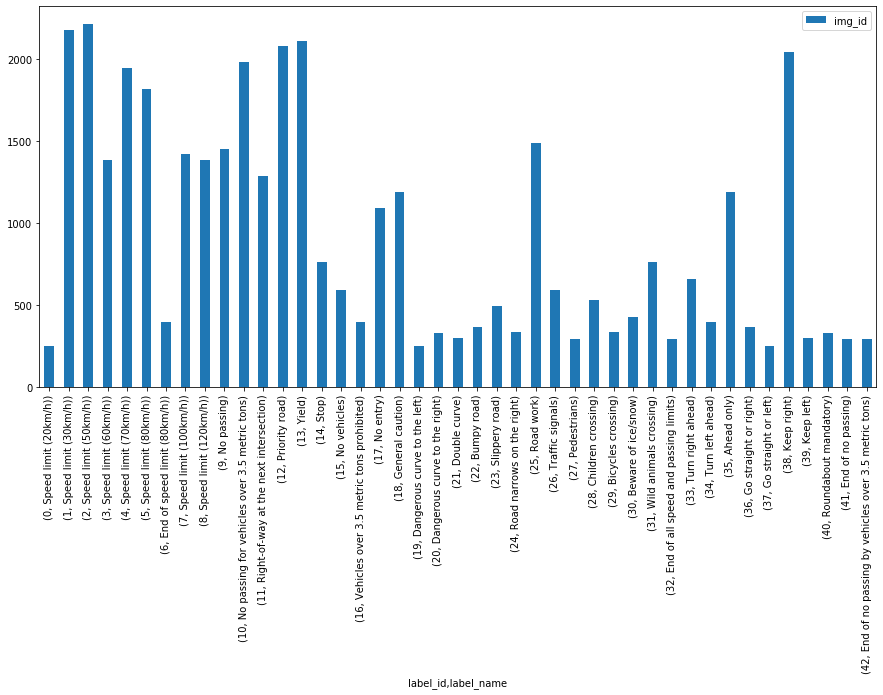

In [18]:
X_train_augs_id_to_label = group_img_id_to_lbl_2(y_train_augs, sign_names)
X_train_augs_group_by_label_count = group_img_id_to_lb_count(X_train_augs_id_to_label)
X_train_augs_group_by_label_count.plot(kind='bar', figsize=(15, 7))

I could reduce the class imbalance to some extent which was observarable in the original data. I did not generate images so that every class have the same number of images because I did not want the model to overwhelmingly learn about augmented images.
Now every class has at least 10% of its dataset augmented.

The below shows visuals of the new dataset, with some images having been augmented by the steps above.

In [19]:
# Plotting images from each of these classes
X_train_augs_group_by_label = X_train_augs_id_to_label.groupby(["label_id", "label_name"])

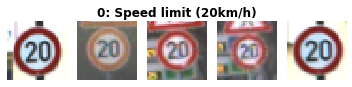

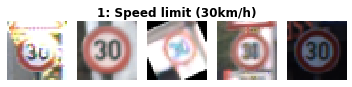

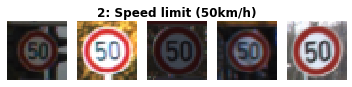

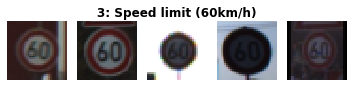

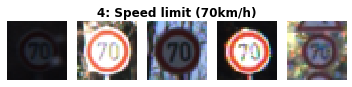

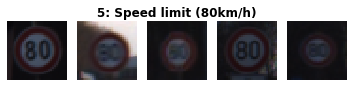

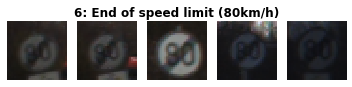

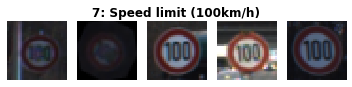

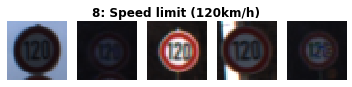

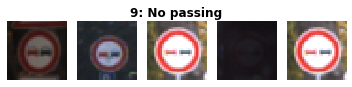

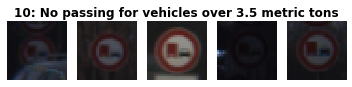

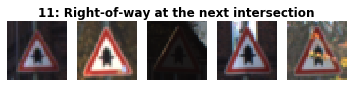

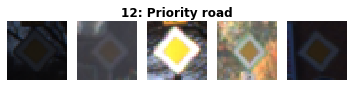

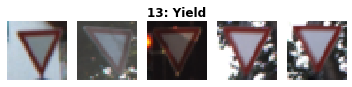

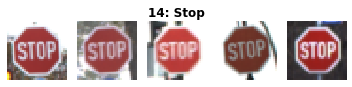

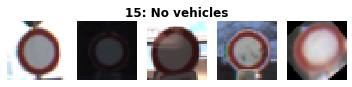

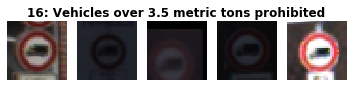

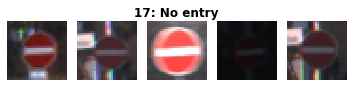

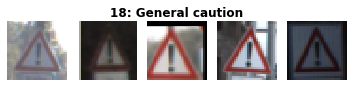

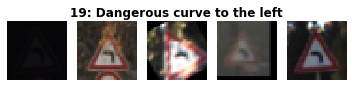

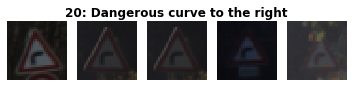

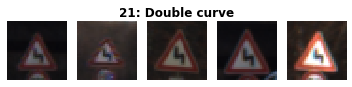

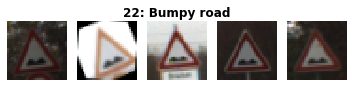

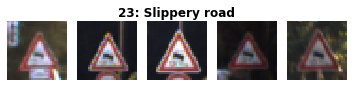

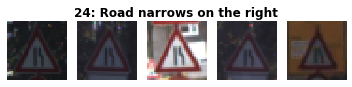

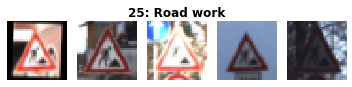

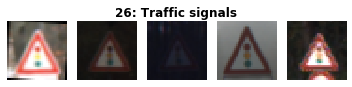

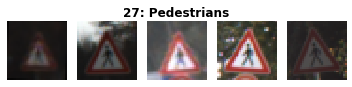

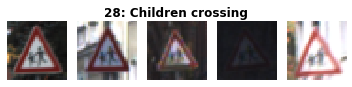

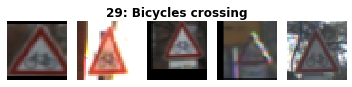

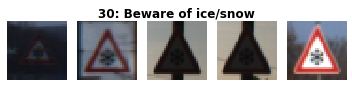

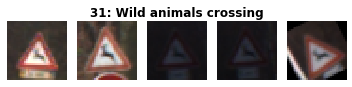

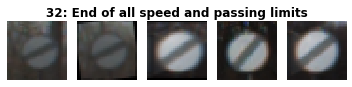

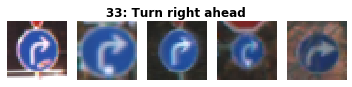

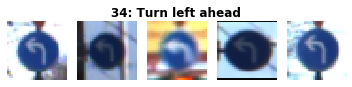

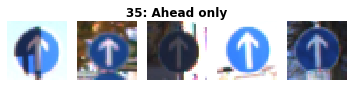

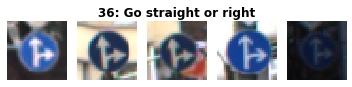

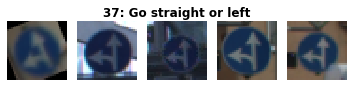

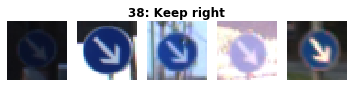

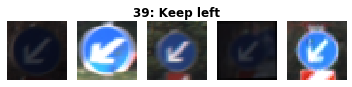

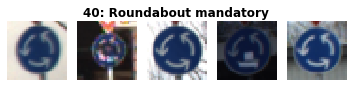

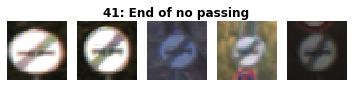

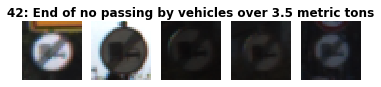

In [42]:
show_random_dataset_images(X_train_augs_group_by_label, X_train_augs)

In [33]:
X_train_aug_model = X_train_augs.reshape(len(X_train_augs), 32*32*3).astype('float32')
y_train_augs_model = to_categorical(y_train_augs, 43)

In [44]:
augmented_model, augmented_model_fit = dense_nn(X_train_aug_model,y_train_augs_model,X_val_baseline,y_val_baseline,X_test_baseline,y_test_baseline, shape =(32*32*3,))

Train on 38836 samples, validate on 4410 samples
Epoch 1/100
38836/38836 [==============================] - 17s 428us/step - loss: 2.7447 - accuracy: 0.2701 - val_loss: 2.1248 - val_accuracy: 0.3395
Epoch 2/100
38836/38836 [==============================] - 9s 233us/step - loss: 1.5009 - accuracy: 0.5555 - val_loss: 1.5277 - val_accuracy: 0.5270
Epoch 3/100
38836/38836 [==============================] - 9s 232us/step - loss: 1.1264 - accuracy: 0.6755 - val_loss: 1.1664 - val_accuracy: 0.6766
Epoch 4/100
38836/38836 [==============================] - 8s 214us/step - loss: 0.9590 - accuracy: 0.7270 - val_loss: 0.8099 - val_accuracy: 0.7351
Epoch 5/100
38836/38836 [==============================] - 9s 227us/step - loss: 0.8314 - accuracy: 0.7659 - val_loss: 0.7423 - val_accuracy: 0.7637
Epoch 6/100
38836/38836 [==============================] - 8s 210us/step - loss: 0.7703 - accuracy: 0.7848 - val_loss: 0.7539 - val_accuracy: 0.7753
Epoch 7/100
38836/38836 [==============================]

In [45]:
augmented_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
Pred_augmented = augmented_model.evaluate(X_test_baseline, y_test_baseline, verbose=0)
print("Dense fully connected network results on the test data - Augmented ")
print(" ")
print("%s- %.2f" % (augmented_model.metrics_names[0], Pred_augmented[0]))
print("%s- %.2f" % (augmented_model.metrics_names[1], Pred_augmented[1]))

Dense fully connected network results on the test data - Augmented 
 
loss- 1.65
accuracy- 0.87


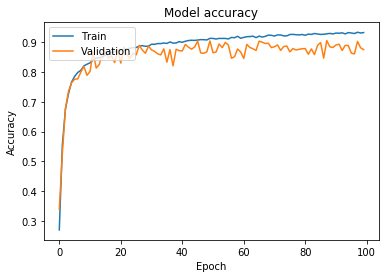

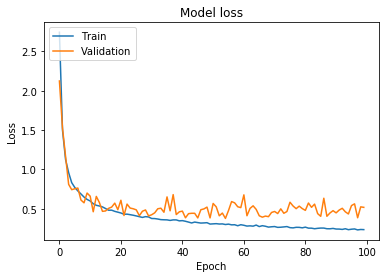

In [46]:
plot_acc_loss(augmented_model_fit)

Now I am going to grayscale the augmented data and fit the same fully connected model.

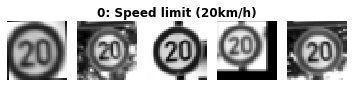

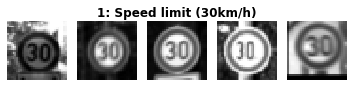

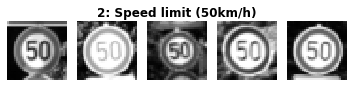

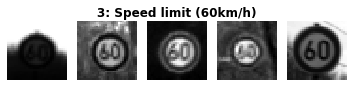

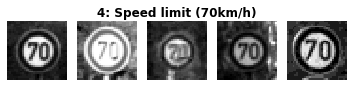

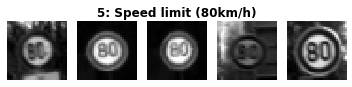

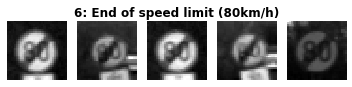

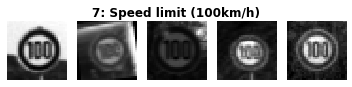

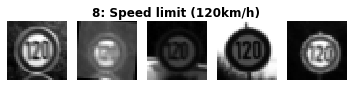

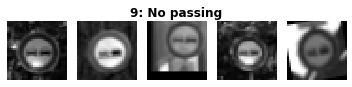

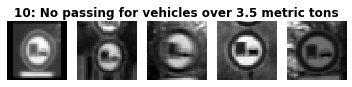

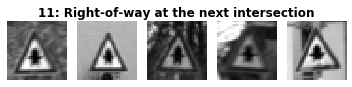

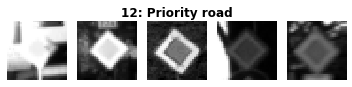

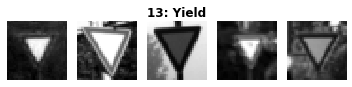

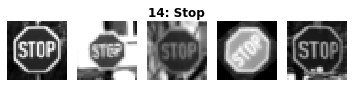

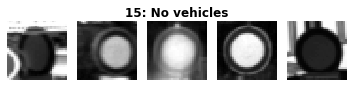

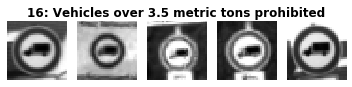

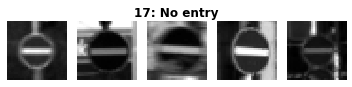

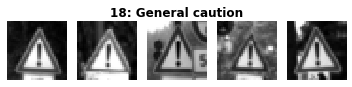

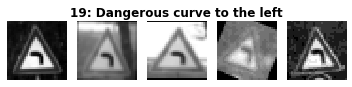

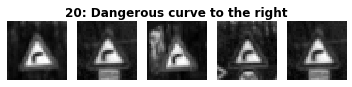

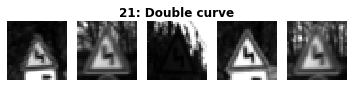

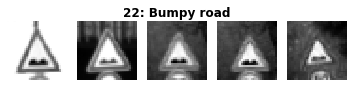

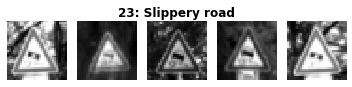

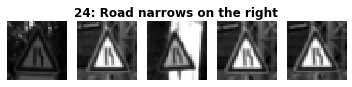

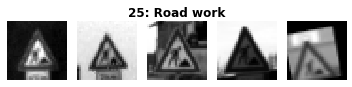

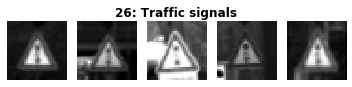

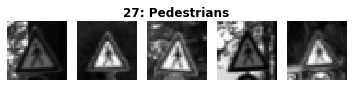

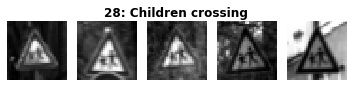

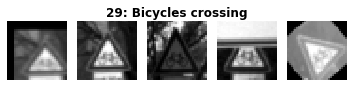

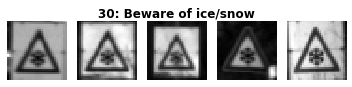

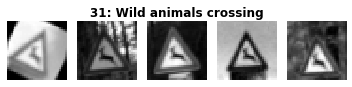

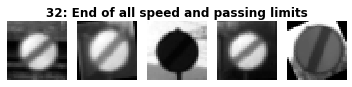

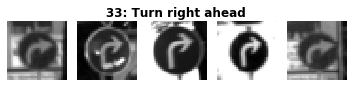

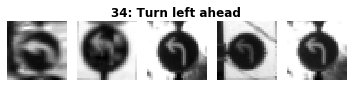

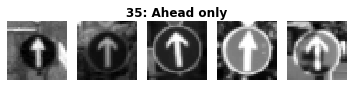

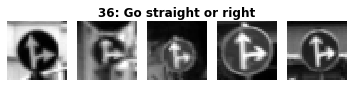

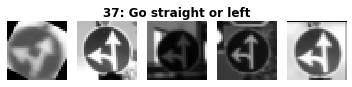

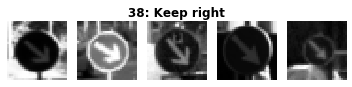

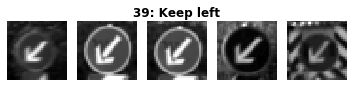

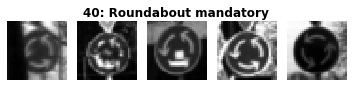

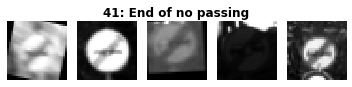

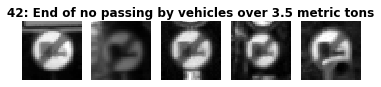

In [23]:
X_train_augs_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train_augs))) 

show_random_dataset_images(X_train_augs_group_by_label, X_train_augs_grayscale)

In [24]:
X_train_augs_grayscale_model = X_train_augs_grayscale.reshape(len(X_train_augs_grayscale), 32*32*1).astype('float32')

In [49]:
augmented_grayscale_model, augmented_grayscale_model_fit = dense_nn(X_train_augs_grayscale_model,y_train_augs_model,X_val_grayscale_model,y_val_grayscale_model,X_test_grayscale_model,y_test_grayscale_model,shape =(32*32*1,))

Train on 38836 samples, validate on 4410 samples
Epoch 1/100
38836/38836 [==============================] - 13s 341us/step - loss: 2.9842 - accuracy: 0.2307 - val_loss: 2.0506 - val_accuracy: 0.4132
Epoch 2/100
38836/38836 [==============================] - 9s 239us/step - loss: 1.6984 - accuracy: 0.5147 - val_loss: 1.7984 - val_accuracy: 0.4791
Epoch 3/100
38836/38836 [==============================] - 10s 254us/step - loss: 1.2964 - accuracy: 0.6340 - val_loss: 1.0316 - val_accuracy: 0.7224
Epoch 4/100
38836/38836 [==============================] - 10s 258us/step - loss: 1.1048 - accuracy: 0.6941 - val_loss: 0.8180 - val_accuracy: 0.7551
Epoch 5/100
38836/38836 [==============================] - 9s 243us/step - loss: 0.9862 - accuracy: 0.7298 - val_loss: 0.9665 - val_accuracy: 0.7152
Epoch 6/100
38836/38836 [==============================] - 9s 232us/step - loss: 0.8995 - accuracy: 0.7505 - val_loss: 0.6853 - val_accuracy: 0.8059
Epoch 7/100
38836/38836 [=============================

38836/38836 [==============================] - 12s 297us/step - loss: 0.3971 - accuracy: 0.8878 - val_loss: 0.3931 - val_accuracy: 0.8937
Epoch 56/100
38836/38836 [==============================] - 11s 283us/step - loss: 0.3923 - accuracy: 0.8898 - val_loss: 0.3983 - val_accuracy: 0.8893
Epoch 57/100
38836/38836 [==============================] - 10s 268us/step - loss: 0.3966 - accuracy: 0.8878 - val_loss: 0.4558 - val_accuracy: 0.8748
Epoch 58/100
38836/38836 [==============================] - 11s 277us/step - loss: 0.3877 - accuracy: 0.8907 - val_loss: 0.3887 - val_accuracy: 0.8884
Epoch 59/100
38836/38836 [==============================] - 11s 288us/step - loss: 0.3921 - accuracy: 0.8894 - val_loss: 0.4746 - val_accuracy: 0.8771
Epoch 60/100
38836/38836 [==============================] - 13s 334us/step - loss: 0.3862 - accuracy: 0.8907 - val_loss: 0.4004 - val_accuracy: 0.8961
Epoch 61/100
38836/38836 [==============================] - 11s 293us/step - loss: 0.3839 - accuracy: 0.892

In [50]:
augmented_grayscale_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
Pred_grayscaled = augmented_grayscale_model.evaluate(X_test_grayscale_model, y_test_grayscale_model, verbose=0)
print("Dense fully connected network results on the test data - Augmented Grayscaled ")
print(" ")
print("%s- %.2f" % (augmented_grayscale_model.metrics_names[0], Pred_grayscaled[0]))
print("%s- %.2f" % (augmented_grayscale_model.metrics_names[1], Pred_grayscaled[1]))

Dense fully connected network results on the test data - Augmented Grayscaled 
 
loss- 0.59
accuracy- 0.88


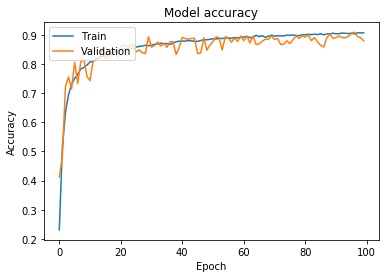

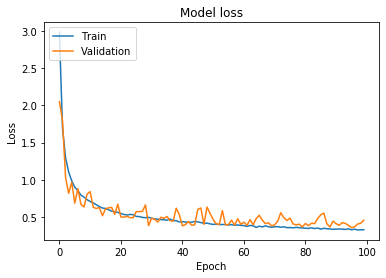

In [51]:
plot_acc_loss(augmented_grayscale_model_fit)

### Model with only one convolutional layer and dense layers

By testing processed data with the feedforward network architecture I decided that augmented grayscaled data is the best training data to move ahead with. Therefore I am constructing a new model architecture by replacing the first dense layer with one convolution layer followed by a max pooling layer to the previous model architecture.

In [52]:
    model_interm = Sequential()
    model_interm.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(32, 32, 1)))
    model_interm.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model_interm.add(MaxPooling2D(pool_size=(2, 2)))
    model_interm.add(BatchNormalization())
    model_interm.add(Flatten())
    model_interm.add(Dense(128, activation='relu'))
    model_interm.add(BatchNormalization())
    model_interm.add(Dropout(0.5))
    model_interm.add(Dense(128, activation='relu'))
    model_interm.add(BatchNormalization())
    model_interm.add(Dropout(0.5))
    model_interm.add(Dense(128, activation='relu'))
    model_interm.add(BatchNormalization())
    model_interm.add(Dense(n_classes, activation='softmax'))

In [34]:
# Prepare data for Conv nets
X_train_processed_cn = X_train_augs_grayscale_model.reshape(len(X_train_augs_grayscale_model), 32,32,1).astype('float32')
X_valid_processed_cn = X_val_grayscale_model.reshape(len(X_val_grayscale_model), 32,32,1).astype('float32')
X_test_processed_cn = X_test_grayscale_model.reshape(len(X_test_grayscale_model), 32,32,1).astype('float32')
y_train_final_cn = y_train_augs_model
y_valid_final_cn = keras.utils.to_categorical(y_valid, n_classes)
y_test_final_cn = keras.utils.to_categorical(y_test, n_classes)

In [54]:
model_interm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_interm_fit = model_interm.fit(X_train_processed_cn, y_train_final_cn, batch_size=128, epochs=100, verbose=1,validation_data=(X_valid_processed_cn, y_valid_final_cn))

Train on 38836 samples, validate on 4410 samples
Epoch 1/100
38836/38836 [==============================] - 146s 4ms/step - loss: 1.8349 - accuracy: 0.5443 - val_loss: 2.6924 - val_accuracy: 0.3875
Epoch 2/100
38836/38836 [==============================] - 138s 4ms/step - loss: 0.4093 - accuracy: 0.9048 - val_loss: 0.3825 - val_accuracy: 0.8925
Epoch 3/100
38836/38836 [==============================] - 138s 4ms/step - loss: 0.2494 - accuracy: 0.9399 - val_loss: 0.1105 - val_accuracy: 0.9683
Epoch 4/100
38836/38836 [==============================] - 140s 4ms/step - loss: 0.1818 - accuracy: 0.9541 - val_loss: 0.1104 - val_accuracy: 0.9649
Epoch 5/100
38836/38836 [==============================] - 137s 4ms/step - loss: 0.1445 - accuracy: 0.9626 - val_loss: 0.0795 - val_accuracy: 0.9764
Epoch 6/100
38836/38836 [==============================] - 135s 3ms/step - loss: 0.1151 - accuracy: 0.9693 - val_loss: 0.0905 - val_accuracy: 0.9755
Epoch 7/100
38836/38836 [==============================] 

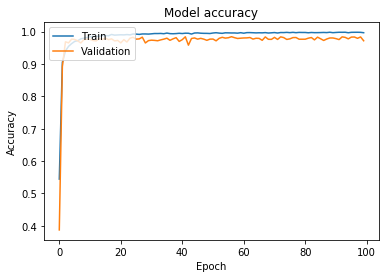

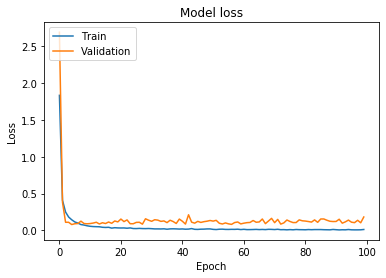

In [62]:
plot_acc_loss(model_interm_fit)

In [63]:
Pred_interm = model_interm.evaluate(X_test_processed_cn, y_test_final_cn, verbose=0)
print("Hybrid network results on the test data")
print(" ")
print("%s- %.2f" % (model_interm.metrics_names[0], Pred_interm[0]))
print("%s- %.2f" % (model_interm.metrics_names[1], Pred_interm[1]))

Hybrid network results on the test data
 
loss- 0.17
accuracy- 0.97


### Convolutional Neural Network

I finally I am going to build a neural network architecture which has only convolution layers, max pooling layers and dropout layers.


In [25]:
model_conv = Sequential()
model_conv.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(32, 32, 1)))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.25))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.5))
model_conv.add(Flatten())
model_conv.add(Dense(128, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(n_classes, activation='softmax'))

In [26]:
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
model_conv_fit = model_conv.fit(X_train_processed_cn, y_train_final_cn, batch_size=128, epochs=100, verbose=1,validation_data=(X_valid_processed_cn, y_valid_final_cn))


Train on 38836 samples, validate on 4410 samples
Epoch 1/100
38836/38836 [==============================] - 186s 5ms/step - loss: 2.0893 - accuracy: 0.4743 - val_loss: 0.6993 - val_accuracy: 0.8125
Epoch 2/100
38836/38836 [==============================] - 169s 4ms/step - loss: 0.4563 - accuracy: 0.8745 - val_loss: 0.1594 - val_accuracy: 0.9481
Epoch 3/100
38836/38836 [==============================] - 168s 4ms/step - loss: 0.2610 - accuracy: 0.9313 - val_loss: 0.0829 - val_accuracy: 0.9721
Epoch 4/100
38836/38836 [==============================] - 178s 5ms/step - loss: 0.1884 - accuracy: 0.9486 - val_loss: 0.0492 - val_accuracy: 0.9884
Epoch 5/100
38836/38836 [==============================] - 183s 5ms/step - loss: 0.1499 - accuracy: 0.9579 - val_loss: 0.0570 - val_accuracy: 0.9823
Epoch 6/100
38836/38836 [==============================] - 168s 4ms/step - loss: 0.1314 - accuracy: 0.9625 - val_loss: 0.0365 - val_accuracy: 0.9905
Epoch 7/100
38836/38836 [==============================]

Epoch 54/100
38836/38836 [==============================] - 165s 4ms/step - loss: 0.0221 - accuracy: 0.9941 - val_loss: 0.0294 - val_accuracy: 0.9925
Epoch 55/100
38836/38836 [==============================] - 165s 4ms/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.0412 - val_accuracy: 0.9889
Epoch 56/100
38836/38836 [==============================] - 166s 4ms/step - loss: 0.0219 - accuracy: 0.9939 - val_loss: 0.0825 - val_accuracy: 0.9807
Epoch 57/100
38836/38836 [==============================] - 168s 4ms/step - loss: 0.0223 - accuracy: 0.9936 - val_loss: 0.0401 - val_accuracy: 0.9941
Epoch 58/100
38836/38836 [==============================] - 166s 4ms/step - loss: 0.0241 - accuracy: 0.9931 - val_loss: 0.0424 - val_accuracy: 0.9939
Epoch 59/100
38836/38836 [==============================] - 166s 4ms/step - loss: 0.0195 - accuracy: 0.9944 - val_loss: 0.0360 - val_accuracy: 0.9921
Epoch 60/100
38836/38836 [==============================] - 167s 4ms/step - loss: 0.0192 - accuracy:

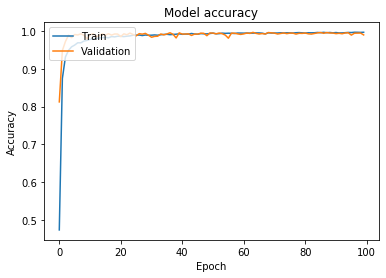

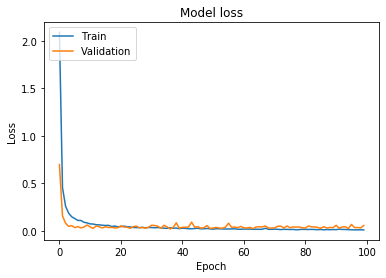

In [38]:
plot_acc_loss(model_conv_fit)

In [39]:
Pred_conv = model_conv.evaluate(X_test_processed_cn, y_test_final_cn, verbose=0)
print("Convolutional neural network results on the test data")
print(" ")
print("%s- %.2f" % (model_conv.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % (model_conv.metrics_names[1], Pred_conv[1]))

Convolutional neural network results on the test data
 
loss- 0.13
accuracy- 0.99


The table below summarises the accuracy and loss values of each of the model tried. Convolutional neural netowrk has the highest accuracy and the second lowest loss.

| Model | Accuracy | Loss
|:-----|------|------|
| Base model- dense/fully connected (without preprocessing) | 0.87 |1.6 |
| Base model- dense/fully connected - Normalised | 0.81 |1.07 |
| Base model- dense/fully connected - Grayscaled | 0.87 |0.7 |
| Base model- dense/fully connected - Augmented | 0.87 |1.65 |
| Base model- dense/fully connected - Augmented- Grayscaled | 0.88 |0.59 |
|One convolution layer and dense layers | 0.97 |0.17 |
|Convolutional neural network | 0.99 |0.13 |